# Data Science: A Road to Safer Roads - Part II


## Introduction

This is in continuation with a previous article. Before picking up the trail, let us have a very quick recap of what we did earlier. We have Seattle's car collision dataset, where the severity of an accident (severity 1, 2, 3 and 4) is to be predicted using predictors like road condition, collision type, light condition, junction type etc. With this data, we performed data cleaning, data visualization, data imputation, exploratory data analysis, feature selection and one-hot encoding.

From this point onwards, taking an easy road, we had

a) converted the multi-class problem to a two-class one (Severity 4 vs the rest of the severities)

b) randomly over-sampled the minority class (Severity 4) to have a balanced data set

c) split data into training and testing set by just dividing the data into two parts according to the specified partitioning ratio, using train_test_split of Scikit-learn library (also called Hold-Out)

d) tried out classification models with accuracy as the measure of model evaluation

We are going to revisit the problem from a different angle.

## Import Packages

In [96]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from IPython.display import HTML

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

## Define Custom Scorer

We obtain precision, recall, f-score from sklearn's metrics **“precision_recall_fscore_support”**, calculated for each class.

Since we are also interested in the weighted average values of too, we define the following custom scorer.

In [97]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'balanced_accuracy': make_scorer(balanced_accuracy_score),
                 'precision': make_scorer(precision_score, average='weighted'),
                 'recall': make_scorer(recall_score, average='weighted'),
                 'roc auc': make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True),
                 'f1': make_scorer(f1_score, average='weighted')
                 }

## Routine for Plotting the Confusion Matrix

In [98]:
def _plot_confusion_matrix(conf_mat, classes, normalize = False, title = 'Confusion Matrix',
                          cmap = plt.cm.Greens, plotscale = 5):
    """
    Plots confusion matrix for binary or multi-class classification
       
    Parameters:
    ----------
        conf_mat: confusion matrix, given test and predicted values of the target (dependent) variable
        classes: comma separated unique class names of the target variable to be predicted
        normalize: boolean flag indicating if normalization is to be applied
        title: title of the confusion matrix plot
        ax: axes object(s) of the plot
        cmap: color map
        plotscale: integer controlling size of the plot and the labels proportionally
    
    Returns:
    -------
        None
    
    """
    
    fig, ax = plt.subplots(figsize = (plotscale, plotscale))
    ax.set_title(title, fontsize = plotscale + 10)
    plt.tick_params(axis = 'x', labelsize = plotscale + 8)
    plt.tick_params(axis = 'y', labelsize = plotscale + 8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = plotscale + 8)
    plt.yticks(tick_marks, classes, size = plotscale + 8)
    plt.sca(ax)
    
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        ax.text(j, i, format(conf_mat[i, j], fmt),
                horizontalalignment = "center",
                color = "white" if conf_mat[i, j] > thresh else "black", size = plotscale + 8)

    ax.set_ylabel('True Label', fontsize = plotscale + 8)
    ax.set_xlabel('Predicted Label', fontsize = plotscale + 8)
    ax.imshow(conf_mat, interpolation = 'nearest', cmap = cmap)
    
    plt.show()
    
    return

## Routine for Plotting ROC and Calculating AUC

In [104]:
def _show_roc(model, X, y, title='Receiver Operating Characteristic Curve', plotscale=8):
    
    """
    Plots ROC curve for multi-class classification
       
    Parameters:
    ----------
        y: Target or dependent variable
        y_proba: probability vector for the classes, predicted by the classifier
        title: title of the ROC curve plot
        size: integer controlling size of the plot
    
    Returns:
    -------
        None
    
    """
    
    # Binarize the output
    y_binarized = label_binarize(y, classes=[1, 2, 3, 4])
    n_classes = y_binarized.shape[1]
    
    model_OneVsRest = OneVsRestClassifier(model)
    
    y_proba = cross_val_predict(model_OneVsRest, X, y, cv=10, method='predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fig, ax = plt.subplots(figsize = (plotscale, plotscale))
    ax.set_title(title, fontsize = plotscale + 10)
    plt.tick_params(axis = 'x', labelsize = plotscale + 8)
    plt.tick_params(axis = 'y', labelsize = plotscale + 8)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = itertools.cycle(['green', 'blue', 'orange', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of Severity {0} (AUC = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    return

## Routine for Showing the Metrics (both Class-specific and Weighted Average)

In [105]:
def _report_metrics(model, X, y, title):
    
    """
    Reports Precision, Recall, F-scores 
       
    Parameters:
    ----------
        model: classification algorithm, e.g.  RandomForestClassifier()
        title: textual description
        X: input feature matrix (independent variable)
        y: input classes (dependent variable)
    
    Returns:
    -------
        y_pred: predicted dependent variable class
        
    """
    
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # evaluate model
    scores = cross_validate(model, X, y, cv=cv, scoring=custom_scorer, n_jobs=-1)
    names = []
    values = []
    # sort the result dictionary
    sorted(scores.keys())

    # print all the metrics
    disp_line = '<h2>' + title + '</h2>'
    display(HTML(disp_line))
    
    for name in scores.keys():
        if not('time' in name):
            names.append(name)
            values.append(np.average(scores[name]))

    disp_line = '<h3>Metrics (average):</h3>'
    display(HTML(disp_line))
    
    score_df = pd.concat([pd.DataFrame(names), pd.DataFrame(values)], axis = 1)
    score_df.columns =['Metric', 'Weighted Average Value'] 
    display(HTML(score_df.to_html(index=False)))  
    
    y_pred = cross_val_predict(model, X, y, cv=10) 

    precision, recall, fscore, support = score(y, y_pred)

    disp_line = '<h3>Metrics (class-wise):</h3>'
    display(HTML(disp_line))
    score_df = pd.DataFrame(list(zip(precision, recall, fscore, support)), 
                        columns =['precision', 'recall', 'fscore', 'support'])
    score_df = pd.concat([pd.DataFrame(classes), score_df], axis = 1)        
    score_df.columns =['Target Class', 'Precision', 'Recall', 'F-score', 'Support'] 
        
    display(HTML(score_df.to_html(index=False)))
    
    return y_pred

## Main Calling Routine to Evaluate Model

In [106]:
def evaluate_model(model, X, y, classes, title, plotscale, show_cmat=True, show_roc=True):
    
    """
    Fits the model with Repated Stratified k-Fold strategy, reports Precision, Recall, F-scores 
    and plots the confusion matrix
       
    Parameters:
    ----------
        model: classification algorithm, e.g.  RandomForestClassifier()
        title: textual description
        plotscale: integer controlling size of the plot and the labels proportionally
    
    Returns:
    -------
        None
    
    """

    y_pred = _report_metrics(model, X, y, title)
    
    if show_cmat == True:
        conf_mat = confusion_matrix(y, y_pred)
        _plot_confusion_matrix(conf_mat, classes=classes, plotscale=plotscale)
    
    if show_roc == True:
        _show_roc(model, X, y, plotscale=plotscale)
        
    return

## Read Data and Populate Arrays for Feature (X) and the Response Variable (y)

In [107]:
df = pd.read_csv('Collisions_data_after_Feature_Selected_unbalanced.csv')

# Set the target for the prediction
target='SEVERITYCODE'

# Create arrays for the features and the response variable
y = df[target]
X = df.drop(target, axis=1)

X = StandardScaler().fit(X).transform(X)

classes = np.unique(df[target])

# Cost-sensitive Classification

A few classifier algorithms have a parameter **“class_weight”** through which we can specify that we are dealing with imbalanced classes. In the light of the above discussion, we shall explore the effectiveness of cost-sensitive classification where we use cross-validation as the training method and Precision, Recall, ROC AUC as metrics.
Previously, we had seen **“RandomForestClassifier”** gave us the maximum accuracy. We take this as rough guide and try out the algorithm with the options it offers to deal with imbalanced data.


## Random Forest with No Class Weighting

Metric,Weighted Average Value
test_accuracy,0.732789
test_balanced_accuracy,0.305566
test_precision,0.707335
test_recall,0.732789
test_roc auc,0.656188
test_f1,0.684174


Target Class,Precision,Recall,F-score,Support
1,0.742965,0.953967,0.835348,137335
2,0.650128,0.252098,0.363315,58628
3,0.115789,0.010673,0.019544,3092
4,0.000000,0.000000,0.000000,349


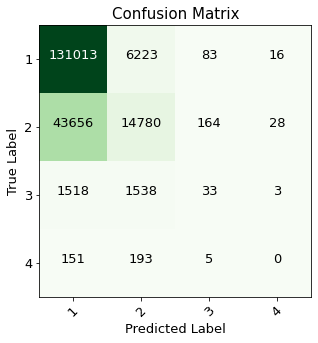

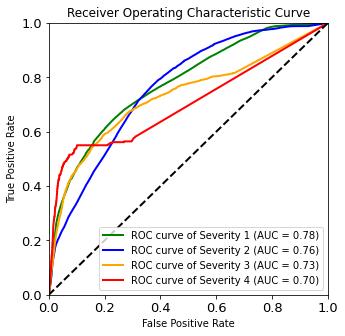

In [108]:
# define model
model = RandomForestClassifier(n_estimators=10, random_state=0)

# evaluate model
evaluate_model(model, X, y, classes, title='No Class Weighting', plotscale=5, show_cmat=True, show_roc=True)


## Random Forest with class_weight = 'balanced'

The **“balanced”** mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 

*n_samples / (n_classes * np.bincount(y))*

Metric,Weighted Average Value
test_accuracy,0.582370
test_balanced_accuracy,0.453552
test_precision,0.729669
test_recall,0.582370
test_roc auc,0.688058
test_f1,0.632531


Target Class,Precision,Recall,F-score,Support
1,0.871685,0.592988,0.705821,137335
2,0.431905,0.581173,0.495542,58628
3,0.048777,0.257439,0.082015,3092
4,0.012165,0.375358,0.023565,349


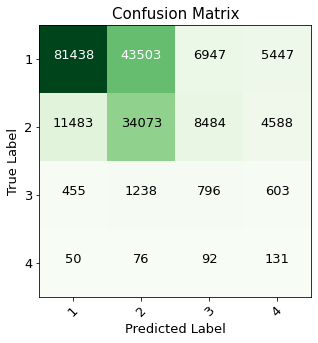

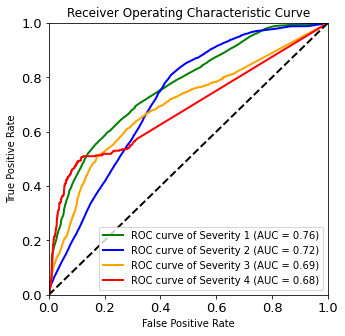

In [83]:
# define model
model = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=0)

# evaluate model
evaluate_model(model, X, y, classes, title='class_weight=balanced', plotscale=5, show_cmat=True, show_roc=True)

## Random Forest with class_weight='balanced_subsample'

The **“balanced_subsample”** mode is the same as **“balanced”** except that weights are computed based on the bootstrap sample for every tree grown.

Metric,Weighted Average Value
test_accuracy,0.582586
test_balanced_accuracy,0.453032
test_precision,0.729850
test_recall,0.582586
test_roc auc,0.689091
test_f1,0.632719


Target Class,Precision,Recall,F-score,Support
1,0.871776,0.593570,0.706264,137335
2,0.432233,0.581326,0.495814,58628
3,0.049251,0.260349,0.082832,3092
4,0.012150,0.372493,0.023532,349


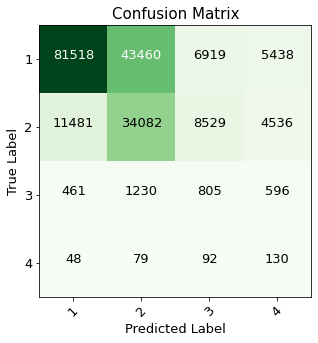

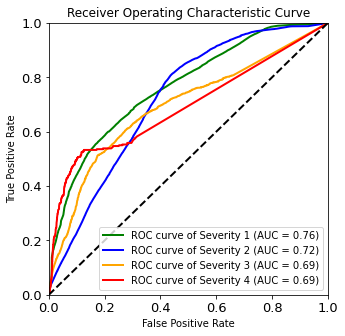

In [84]:
# define model
model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=0)

# evaluate model
evaluate_model(model, X, y, classes, title='class_weight=balanced_subsample', plotscale=5, show_cmat=True, show_roc=True)